In [1]:
import numpy as np
from urllib.request import urlopen
import scipy.optimize
import random
from math import exp
from math import log
from prettytable import PrettyTable

In [2]:
def parseData(fname):
  for l in urlopen(fname):
    yield eval(l)

print("Reading data...")
data = list(parseData("http://jmcauley.ucsd.edu/cse190/data/beer/beer_50000.json"))
print("Done")

def feature(datum):
  feat = [1, datum['review/taste'], datum['review/appearance'], datum['review/aroma'], datum['review/palate'], datum['review/overall']]
  return feat

X = [feature(d) for d in data]
y = [d['beer/ABV'] >= 6.5 for d in data]

def inner(x,y):
  return sum([x[i]*y[i] for i in range(len(x))])

def sigmoid(x):
  return 1.0 / (1 + exp(-x))

Reading data...
Done


In [3]:
##################################################
# Logistic regression by gradient ascent         #
##################################################

# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
  loglikelihood = 0
  for i in range(len(X)):
    logit = inner(X[i], theta)
    loglikelihood -= log(1 + exp(-logit))
    if not y[i]:
      loglikelihood -= logit
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print("ll =" + str(loglikelihood))
  return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      dl[k] += X[i][k] * (1 - sigmoid(logit))
      if not y[i]:
        dl[k] -= X[i][k]
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return np.array([-x for x in dl])


In [4]:
X_train = X
y_train = y

In [5]:
# split into 1/3 train, 1/3 validation, 1/3 test

Z = list(zip(X, y))

random.shuffle(Z)

x_shuffled, y_shuffled = zip(*Z)

print("X shuffled: ", np.shape(x_shuffled))
print("y shuffled: ", np.shape(y_shuffled))

samples = len(x_shuffled)

X_train = x_shuffled[0:round(samples/3)];
y_train = y_shuffled[0:round(samples/3)];

X_validation = x_shuffled[round(samples/3) + 1: 2 * round(samples/3)]
y_validation = y_shuffled[round(samples/3) + 1: 2 * round(samples/3)]

X_test = x_shuffled[2 * round(samples/3) + 1:samples]
y_test = y_shuffled[2 * round(samples/3) + 1:samples]

print("x train: ", np.shape(X_train), "x validate: ", np.shape(X_validation), "x test: ", np.shape(X_test))
print("y train: ", np.shape(y_train), "y validate: ", np.shape(y_validation), "y test: ", np.shape(y_test))



X shuffled:  (50000, 6)
y shuffled:  (50000,)
x train:  (16667, 6) x validate:  (16666, 6) x test:  (16665, 6)
y train:  (16667,) y validate:  (16666,) y test:  (16665,)


In [6]:
##################################################
# Train                                          #
##################################################

def train(lam):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, args = (X_train, y_train, lam))
  return theta


In [7]:
##################################################
# Predict                                        #
##################################################

def performance(theta, X, y):
  scores = [inner(theta,x) for x in X]
  predictions = [s > 0 for s in scores]
    
  positives = sum(predictions)
  negatives = len(predictions) - sum(predictions)
    
  correct = [(a==b) for (a,b) in zip(predictions, y)]
    
  truePositives = sum(correct)
  trueNegatives = len(correct) - sum(correct)

  falsePositives = sum([(a==1 and b==0) for (a,b) in zip(predictions,y)])
  falseNegatives = sum([(a==0 and b==1) for (a,b) in zip(predictions,y)])
 
  acc = sum(correct) * 1.0 / len(correct)
  return acc, positives, negatives, truePositives, trueNegatives, falsePositives, falseNegatives


In [8]:
##################################################
# Validation pipeline                            #
##################################################
lam = 1.0
theta = train(lam)

In [10]:
corpusX = [X_train, X_validation, X_test]
corpusY = [y_train, y_validation, y_test]

acc = []
positives = []
negatives = []
truePositives = []
trueNegatives = []
falsePositives = []
falseNegatives = []

for (x, y) in zip(corpusX, corpusY):
    _acc, _positives, _negatives, _truePositives, _trueNegatives, _falsePositives, _falseNegatives \
        = performance(theta, x, y)

    acc.append(_acc)
    positives.append(_positives)
    negatives.append(_negatives)
    truePositives.append(_truePositives)
    trueNegatives.append(_trueNegatives)
    falsePositives.append(_falsePositives)
    falseNegatives.append(_falseNegatives)
    

t = PrettyTable(['Lambda = ' + str(lam), 'Train', 'Validation', 'Test'])
t.add_row(["Accuracy"] + acc)
t.add_row(["Positives"] + positives)
t.add_row(["Negatives"] + negatives)
t.add_row(["True Positives"] + truePositives)
t.add_row(["True Negatives"] + trueNegatives)
t.add_row(["False Positives"] + falsePositives)
t.add_row(["False Negatives"] + falseNegatives)
print(t)

+-----------------+--------------------+--------------------+--------------------+
|   Lambda = 1.0  |       Train        |     Validation     |        Test        |
+-----------------+--------------------+--------------------+--------------------+
|     Accuracy    | 0.7212455750884982 | 0.7137885515420617 | 0.7189318931893189 |
|    Positives    |       12463        |       12300        |       12408        |
|    Negatives    |        4204        |        4366        |        4257        |
|  True Positives |       12021        |       11896        |       11981        |
|  True Negatives |        4646        |        4770        |        4684        |
| False Positives |        3349        |        3363        |        3339        |
| False Negatives |        1297        |        1407        |        1345        |
+-----------------+--------------------+--------------------+--------------------+


In [11]:
# NEGATIVE Log-likelihood
def f2(theta, X, y, lam):
  loglikelihood = 0
  for i in range(len(X)):
    logit = inner(X[i], theta)
    loglikelihood -= log(1 + exp(-logit))
    if not y[i]:
      loglikelihood -= (log(10)*logit)
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print("ll =" + str(loglikelihood))
  return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime2(theta, X, y, lam):
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      dl[k] += X[i][k] * (1 - sigmoid(logit))
      if not y[i]:
        dl[k] -= (log(10)*X[i][k])
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return np.array([-x for x in dl])

def train2(lam):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f2, [0]*len(X[0]), fprime2, pgtol = 10, args = (X_train, y_train, lam))
  return theta


In [12]:
lam = 1.0
theta = train2(lam)

acc = []
positives = []
negatives = []
truePositives = []
trueNegatives = []
falsePositives = []
falseNegatives = []

for (x, y) in zip(corpusX, corpusY):
    _acc, _positives, _negatives, _truePositives, _trueNegatives, _falsePositives, _falseNegatives \
        = performance(theta, x, y)

    acc.append(_acc)
    positives.append(_positives)
    negatives.append(_negatives)
    truePositives.append(_truePositives)
    trueNegatives.append(_trueNegatives)
    falsePositives.append(_falsePositives)
    falseNegatives.append(_falseNegatives)
    

t = PrettyTable(['Lambda = ' + str(lam), 'Train', 'Validation', 'Test'])
t.add_row(["Accuracy"] + acc)
t.add_row(["Positives"] + positives)
t.add_row(["Negatives"] + negatives)
t.add_row(["True Positives"] + truePositives)
t.add_row(["True Negatives"] + trueNegatives)
t.add_row(["False Positives"] + falsePositives)
t.add_row(["False Negatives"] + falseNegatives)
print(t)

+-----------------+--------------------+--------------------+--------------------+
|   Lambda = 1.0  |       Train        |     Validation     |        Test        |
+-----------------+--------------------+--------------------+--------------------+
|     Accuracy    | 0.5063898722025559 | 0.5093603744149766 | 0.5051305130513052 |
|    Positives    |        2938        |        2859        |        2867        |
|    Negatives    |       13729        |       13807        |       13798        |
|  True Positives |        8440        |        8489        |        8418        |
|  True Negatives |        8227        |        8177        |        8247        |
| False Positives |        377         |        346         |        350         |
| False Negatives |        7850        |        7831        |        7897        |
+-----------------+--------------------+--------------------+--------------------+


In [13]:
lambdas = [0, 0.01, 0.1, 1, 100]
labels  = ["Training Set", "Validation Set", "Testing Set"]
corpusX = [X_train, X_validation, X_test]
corpusY = [y_train, y_validation, y_test]

acc = []
positives = []
negatives = []
truePositives = []
trueNegatives = []
falsePositives = []
falseNegatives = []

for lam in lambdas:
    theta = train(lam)
    for (x, y) in zip(corpusX, corpusY):
        _acc, _positives, _negatives, _truePositives, _trueNegatives, _falsePositives, _falseNegatives \
            = performance(theta, x, y)
            
        acc.append(_acc)
        positives.append(_positives)
        negatives.append(_negatives)
        truePositives.append(_truePositives)
        trueNegatives.append(_trueNegatives)
        falsePositives.append(_falsePositives)
        falseNegatives.append(_falseNegatives)

In [14]:
idx = 0
for lam in lambdas:
    t = PrettyTable(['Lambda = ' + str(lam), 'Train', 'Validation', 'Test'])
    t.add_row(["Accuracy"] + acc[idx:idx+3])
    t.add_row(["Positives"] + positives[idx:idx+3])
    t.add_row(["Negatives"] + negatives[idx:idx+3])
    t.add_row(["True Positives"] + truePositives[idx:idx+3])
    t.add_row(["True Negatives"] + trueNegatives[idx:idx+3])
    t.add_row(["False Positives"] + falsePositives[idx:idx+3])
    t.add_row(["False Negatives"] + falseNegatives[idx:idx+3])
    print(t)
    idx += 3

+-----------------+--------------------+--------------------+--------------------+
|    Lambda = 0   |       Train        |     Validation     |        Test        |
+-----------------+--------------------+--------------------+--------------------+
|     Accuracy    | 0.7226855462890742 | 0.7141485659426378 | 0.7191119111911191 |
|    Positives    |       12389        |       12238        |       12349        |
|    Negatives    |        4278        |        4428        |        4316        |
|  True Positives |       12045        |       11902        |       11984        |
|  True Negatives |        4622        |        4764        |        4681        |
| False Positives |        3300        |        3329        |        3308        |
| False Negatives |        1322        |        1435        |        1373        |
+-----------------+--------------------+--------------------+--------------------+
+-----------------+--------------------+--------------------+--------------------+
|  L

In [15]:
### Network visualization ###
import networkx as nx
import matplotlib.pyplot as plt

In [16]:
edges = set()
nodes = set()
for edge in urlopen("http://jmcauley.ucsd.edu/cse255/data/facebook/egonet.txt"):
  x,y = edge.split()
  x,y = int(x),int(y)
  edges.add((x,y))
  edges.add((y,x))
  nodes.add(x)
  nodes.add(y)

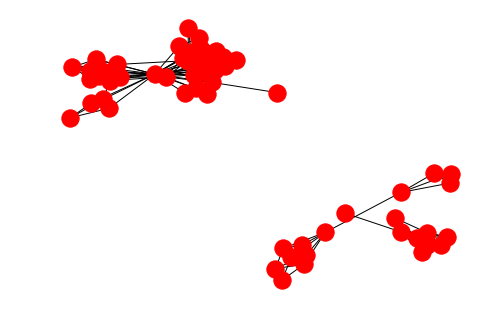

In [17]:
G = nx.Graph()
for e in edges:
  G.add_edge(e[0],e[1])
nx.draw(G)
plt.show()
plt.clf()

In [18]:
print("Number of Connected Components: ", nx.number_connected_components(G))
print("Largest Connected Component:", max([len(x) for x in nx.connected_components(G)]))

Number of Connected Components:  3
Largest Connected Component: 40


In [19]:
largest_cc = sorted(max(nx.connected_components(G), key=len))

half = round(len(largest_cc)/2)

split_lo = largest_cc[:half]
split_hi = largest_cc[half:]

print("Low IDs:  ", split_lo)
print("High IDs: ", split_hi)
print("Normalized Cut Cost: ", (1/2)*nx.normalized_cut_size(G, split_lo, split_hi))

Low IDs:   [697, 703, 708, 713, 719, 729, 745, 747, 753, 769, 772, 774, 798, 800, 803, 804, 805, 810, 811, 819]
High IDs:  [823, 825, 828, 830, 840, 856, 861, 863, 864, 869, 876, 878, 880, 882, 884, 886, 888, 889, 890, 893]
Normalized Cut Cost:  0.4224058769513316


In [20]:
largest_cc = sorted(max(nx.connected_components(G), key=len))

half = round(len(largest_cc)/2)

split_lo = largest_cc[:half]
split_hi = largest_cc[half:]

prevCost = 0;
currCost = (1/2)*nx.normalized_cut_size(G, split_lo, split_hi)

iter = 0
while prevCost != currCost:
    iter += 1
    prevCost = currCost
    print("current cost: ", currCost)
    lo = [i for i in split_lo] # deep copy
    hi = [i for i in split_hi] # deep copy
    
    # move lo to hi if cut cost is lower
    for val in split_lo:          
        lo.remove(val)
        hi.append(val)
        newCost = (1/2)*nx.normalized_cut_size(G, lo, hi)
        
        if(newCost > currCost): # not lower, restore
            lo.append(val)
            hi.remove(val)
        else:
            currCost = newCost # update current cost

    # move hi to lo if cut cost is lower
    for val in split_hi:
        lo.append(val)
        hi.remove(val)
        newCost = (1/2)*nx.normalized_cut_size(G, lo, hi)
        
        if(newCost > currCost): # not lower, restore
            lo.remove(val)
            hi.append(val)
        else:
            currCost = newCost # update current cost
           
    split_lo = [i for i in lo] # deep copy
    split_hi = [i for i in hi] # deep copy
    
print("\nNumber of Iterations: ", iter)
print("Cluster 1: ", sorted(split_hi))
print("Cluster 2: ", sorted(split_lo))
print("Normalized Cut Cost: ", (1/2)*nx.normalized_cut_size(G, split_lo, split_hi))

current cost:  0.4224058769513316
current cost:  0.1624924461156248
current cost:  0.09817045961624274

Number of Iterations:  3
Cluster 1:  [729, 804, 825, 861, 863, 864, 876, 878, 882, 884, 886, 888, 889, 893]
Cluster 2:  [697, 703, 708, 713, 719, 745, 747, 753, 769, 772, 774, 798, 800, 803, 805, 810, 811, 819, 823, 828, 830, 840, 856, 869, 880, 890]
Normalized Cut Cost:  0.09817045961624274


In [45]:
def totalEdges(cluster):
    count = 0
    for i in range(0, len(cluster)):
        for j in range(i, len(cluster)):
            if(G.has_edge(cluster[i], cluster[j])):
                count += 1
    return count

def totalAdjEdges(cluster1, cluster2):
    count = 0
    for i in range(0, len(cluster1)):
        for j in range(0, len(cluster2)):
            if(G.has_edge(cluster1[i], cluster2[j])):
                count += 1
    return count
    
def ekk(cluster, numEdges):
    count = 0
    for i in range(0, len(cluster)):
        for j in range(i, len(cluster)):
            if(G.has_edge(cluster[i], cluster[j])):
                count += 1
    return count/numEdges

def ak(cluster, numEdges, numAdjEdges):
    count = numAdjEdges
    for i in range(0, len(cluster)):
        for j in range(i, len(cluster)):
            if(G.has_edge(cluster[i], cluster[j])):
                count += 1
    return count/numEdges

def findQ(clusters, numEdges, numAdjEdges):
    Q = 0
    for c in clusters:
        Q += ekk(c, numEdges) - ak(c, numEdges, numAdjEdges)*ak(c, numEdges, numAdjEdges)
    return Q

In [46]:
largest_cc = sorted(max(nx.connected_components(G), key=len))

half = round(len(largest_cc)/2)

split_lo = largest_cc[:half]
split_hi = largest_cc[half:]

numEdges = totalEdges(largest_cc)
numAdjEdges = totalAdjEdges(split_lo, split_hi)

prevQ = 0;
currQ = findQ([split_lo, split_hi], numEdges, numAdjEdges)

iter = 0
while prevQ != currQ:
    iter += 1
    prevQ = currQ
    numAdjEdges = totalAdjEdges(split_lo, split_hi)
    
    print("Current modularity: ", currQ)
    lo = [i for i in split_lo] # deep copy
    hi = [i for i in split_hi] # deep copy
    
    # move lo to hi if cut cost is lower
    for val in split_lo:          
        lo.remove(val)
        hi.append(val)
        newQ = findQ([lo, hi], numEdges, numAdjEdges)
        
        if(newQ < currQ): # lower, restore
            lo.append(val)
            hi.remove(val)
        else:
            currQ = newQ # update current cost

    # move hi to lo if cut cost is lower
    for val in split_hi:
        lo.append(val)
        hi.remove(val)
        newQ = findQ([lo, hi], numEdges, numAdjEdges)

        if(newQ < currQ): # lower, restore
            lo.remove(val)
            hi.append(val)
        else:
            currQ = newQ # update current cost
           
    split_lo = [i for i in lo] # deep copy
    split_hi = [i for i in hi] # deep copy
    
print("\nNumber of Iterations: ", iter)
print("Cluster 1: ", sorted(split_hi))
print("Cluster 2: ", sorted(split_lo))
print("Max Modularity Cost: ", findQ([split_lo, split_hi], numEdges, 1))

Current modularity:  -0.4288016528925619
Current modularity:  -0.39396694214876027

Number of Iterations:  2
Cluster 1:  [697, 703, 713, 798, 828, 830, 840, 856, 869, 876, 878, 880, 882, 884, 886, 888, 889, 890, 893]
Cluster 2:  [708, 719, 729, 745, 747, 753, 769, 772, 774, 800, 803, 804, 805, 810, 811, 819, 823, 825, 861, 863, 864]
Max Modularity Cost:  0.35433884297520657
